In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, LinearRegression
import xgboost as xgb

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [2]:
path_ = os.path.expanduser('~/Documents/tidyredfin_data_202202021314.csv')

df = pd.read_csv(path_)

In [3]:
# functions
def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

def dummy_encode_zipcode(df):
    most_frequent_zip_codes = [97209, 97201, 97239, 97217, 97210, 97219]

    for zipcode in most_frequent_zip_codes:
        df['zip_' + str(zipcode)] = 1 * (df['ZIPCODE'] == zipcode)
    return df

def dummy_encode_address_direction(df):
    return (
        pd.concat([df, pd.get_dummies(df['address_direction'], drop_first=False)], axis=1)
        .drop(['E', 'N', 'W', 'S', 'address_direction'], axis=1)
    )

def rmse_cv(model, data, target):
    scores = cross_val_score(model, data, target, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    print("Scores: ", rmse_scores)
    print("Mean: ", rmse_scores.mean())
    print("Std: ", rmse_scores.std())
   
def process_data_for_model(df):
    df = df.dropna() # Drop missing values since they're so few and look randomly distributed

    return (
        df
        .assign(months_since_2021=np.where(df['SOLD_YEAR'] == 2022, df['SOLD_MONTH'] + 12, df['SOLD_MONTH'])) # Standardize sale date to numeric
        .pipe(dummy_encode_address_direction) # Make dummy variables for address direction
        .pipe(dummy_encode_zipcode) # dummy encode the 6 most frequent zipcodes
        .drop(['index', 'SOLD_YEAR', 'SOLD_MONTH', 'ADDRESS', 'ZIPCODE', 'address_building'], axis=1) # drop unnecessary columns
    )

In [4]:
model_data = process_data_for_model(df)

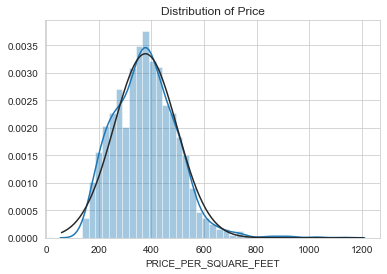

In [5]:
sns.distplot(model_data['PRICE_PER_SQUARE_FEET'], fit=stats.norm)
plt.title('Distribution of Price')
plt.show()

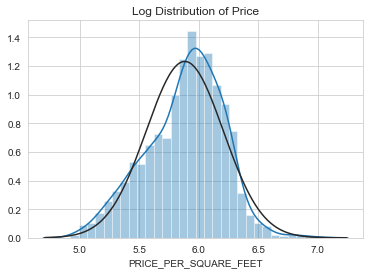

In [6]:
sns.distplot(np.log(model_data['PRICE_PER_SQUARE_FEET']), fit=stats.norm)
plt.title('Log Distribution of Price')
plt.show()

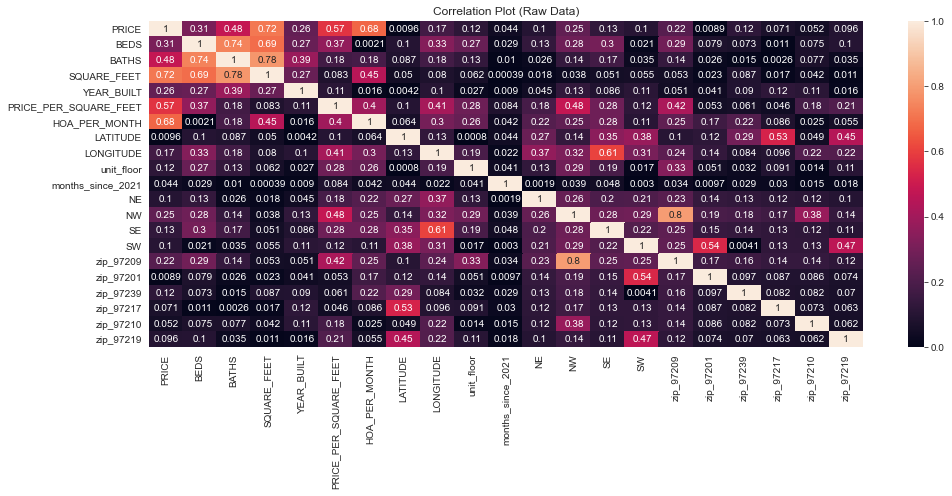

In [7]:
numeric_corr_raw = model_data.corr().abs()

plt.figure(figsize=(16, 6))
sns.heatmap(numeric_corr_raw, vmin=0, vmax=1, annot=True)
plt.title('Correlation Plot (Raw Data)')
plt.show()

In [8]:
X = model_data.drop(['PRICE', 'PRICE_PER_SQUARE_FEET'], axis=1)
y = model_data['PRICE_PER_SQUARE_FEET']

X = sm.add_constant(X)

regression = sm.OLS(y, X).fit()

print(f"OLS RMSE: ${rmse(y, regression.predict(X)).round()}")

OLS RMSE: $82.0


In [9]:
X = model_data.drop(['PRICE', 'PRICE_PER_SQUARE_FEET'], axis=1)
y = model_data['PRICE_PER_SQUARE_FEET']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

In [10]:
knn = KNeighborsRegressor()

model_params = {
    'model__n_neighbors': [3, 5, 7],
    'model__weights': ['uniform', 'distance']
}

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', knn)
])

knn_grid_search = GridSearchCV(knn_pipeline, model_params)
knn_grid_search.fit(X_train, y_train)


rmse_cv(model=knn_grid_search, data=X_train, target=y_train)

Scores:  [74.15805373 72.34597373 74.40019911 63.06856905 70.5750644 ]
Mean:  70.90957200515153
Std:  4.156767584909462


In [11]:
knn_grid_search.best_params_

{'model__n_neighbors': 5, 'model__weights': 'distance'}

In [12]:
gb_trees = xgb.XGBRegressor(random_state=1)

model_params = {
    'model__eta': [0.3, 0.1, 0.01],
    'model__max_depth': [3, 6, 9],
    'model__lambda': [1, 0.9, 0.7]
}

xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', gb_trees)
])

xgb_grid_search = GridSearchCV(xgb_pipeline, model_params)
xgb_grid_search.fit(X_train, y_train)


rmse_cv(model=xgb_grid_search, data=X_train, target=y_train)

Scores:  [60.59143168 61.01457631 63.55005996 51.36087382 55.91075858]
Mean:  58.48554007050734
Std:  4.33290974820801


In [13]:
xgb_grid_search.best_params_

{'model__eta': 0.1, 'model__lambda': 0.7, 'model__max_depth': 6}

In [14]:
ridge = Ridge()

model_params = {
    'model__alpha': [1, 0.5, 0.1]
}

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ridge)
])

ridge_grid_search = GridSearchCV(ridge_pipeline, model_params)
ridge_grid_search.fit(X_train, y_train)


rmse_cv(model=ridge_grid_search, data=X_train, target=y_train)

Scores:  [90.15759398 88.60736473 91.30378547 73.87341847 80.08037881]
Mean:  84.80450829252216
Std:  6.740385321481188


In [15]:
lin_reg = LinearRegression()

lin_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', lin_reg)
])

lin_reg_pipeline.fit(X_train, y_train)

rmse_cv(model=lin_reg_pipeline, data=X_train, target=y_train)

Scores:  [90.14772692 88.61180179 91.31177854 73.89696006 80.0894264 ]
Mean:  84.81153874294965
Std:  6.731959501086501


TO DO:

* More feature engineering: add distance to downtown (duplicative?) and distance to Willamete River

* Get SHAP values for XGB

* PolynomialFeatures?

* More exhaustive grid search to try improve accuracy
